# Image classification: dogs & cats

In [3]:
# Handle imports up-front
import glob
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing import image

# Silence info. messages from TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'

import utils


In [4]:


import glob


# Set the path to the unzipped training data
training_data_path = '../src/train'
testing_data_path = '../src/test1/'

training_dogs = glob.glob(f'{training_data_path}/dog_images/dog.*.jpg')
training_cats = glob.glob(f'{training_data_path}/cat_images/cat.*.jpg')

print("Dog images:", len(training_dogs))
print("Cat images:", len(training_cats))

Dog images: 10500
Cat images: 10500


In [5]:
import glob
import numpy as np
from tensorflow.keras.preprocessing import image

# Set the path to your test images
testing_data_path = '../src/test1/'

# Grab all JPG image paths in the test directory and subdirectories
test_image_paths = glob.glob(f'{testing_data_path}/**/*.jpg', recursive=True)

# Define image dimensions to match your model input
IMAGE_HEIGHT = 48
IMAGE_WIDTH = 64

# Function to load and preprocess each image
def load_and_preprocess_image(img_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH)):
    img = image.load_img(img_path, target_size=target_size)  # PIL image
    img_array = image.img_to_array(img)                      # (H, W, 3)
    img_array = img_array / 255.0                            # Normalize
    return img_array



## 1. Data preparation

### 1.1. Load the data paths

In [6]:
# Set the path to the training data
training_data_path='../src/train'

# Get a list of training dog and cat images
dog_images=glob.glob(f'{training_data_path}/dog_images/dog.*')
cat_images=glob.glob(f'{training_data_path}/cat_images/cat.*')

### 1.2. Inspect

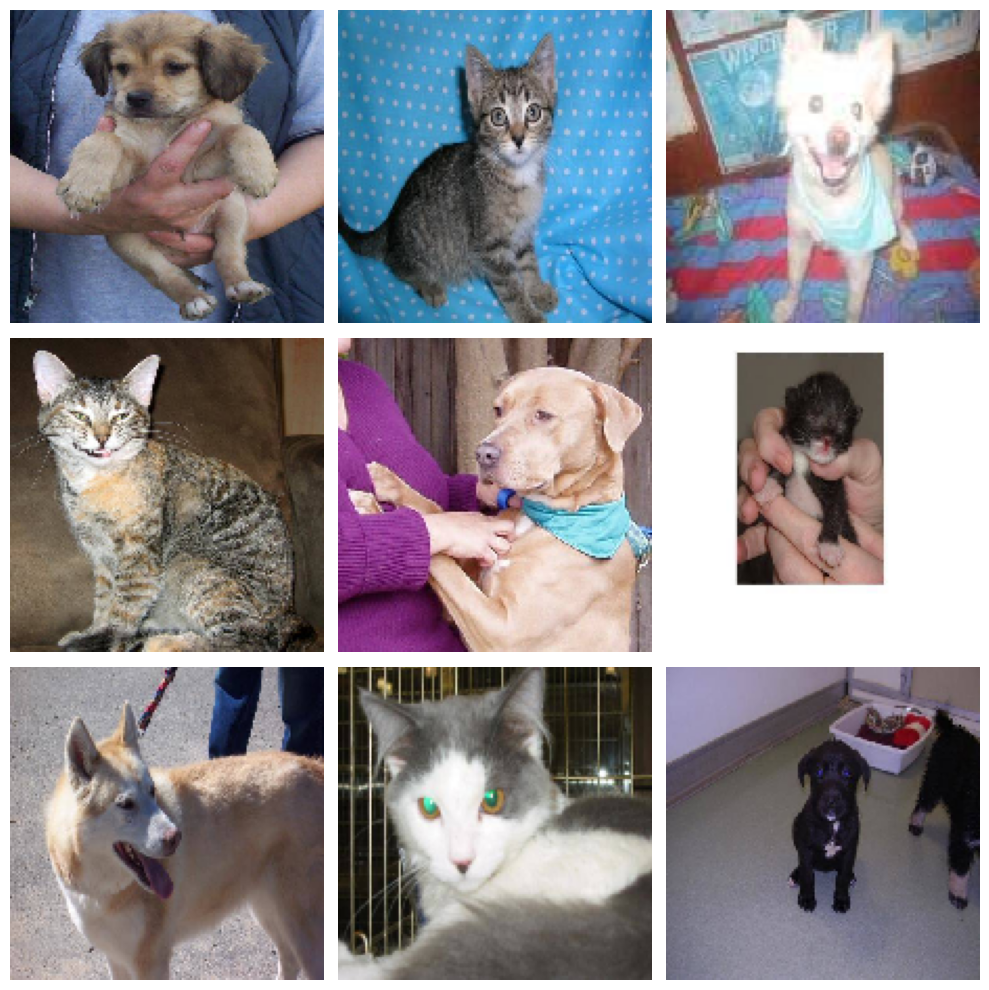

In [7]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# assuming dog_images and cat_images are lists of image file paths
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    if i % 2 == 0:
        img_path = dog_images[i // 2]  # 0, 1, 2... up to len(dog_images)
    else:
        img_path = cat_images[i // 2]  # same index logic for cats
    img = image.load_img(img_path, target_size=(150, 150))
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

Loading: ../src/train/cat_images/cat.5077.jpg


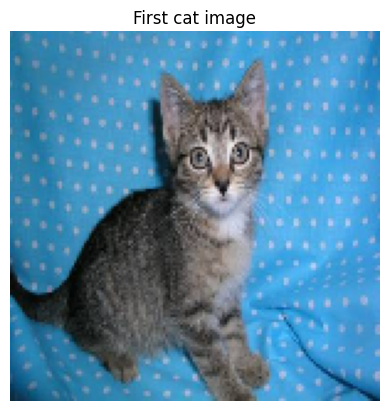

In [8]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Use the actual full path based on your working directory
cat_dir = "../src/train/cat_images"

# List image files
cat_files = [f for f in os.listdir(cat_dir) if f.endswith(".jpg")]

# Safety check and display
if not cat_files:
    print("No JPG images found in folder.")
else:
    cat_path = os.path.join(cat_dir, cat_files[0])
    print(f"Loading: {cat_path}")
    img = image.load_img(cat_path, target_size=(150, 150))
    plt.imshow(img)
    plt.axis('off')
    plt.title("First cat image")
    plt.show()

## 2. EDA

Let's take a look at a few of our images to get a feel for how image data is structured.

### 2.1. Image data

In [9]:
# Load one of the images as an array and look at it's shape - what do you see, what are the dimensions? Are they what you expect?

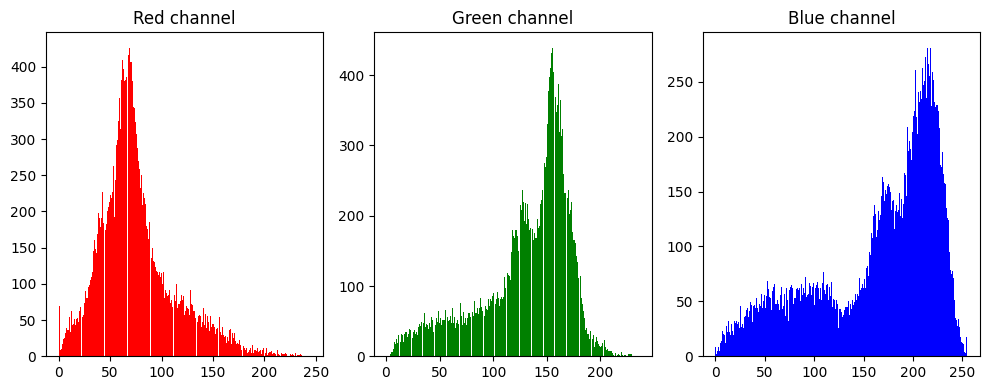

In [10]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Example: loading an image (you may already have img)
# img = Image.open('your_image.jpg')

# Convert to numpy array
img_array = np.array(img)

# Now plot the histogram
fig, axs = plt.subplots(1, 3, figsize=(10, 4))  # 1 row, 3 columns
hist_channels = ['Red', 'Green', 'Blue']
for i in range(3):
    axs[i].hist(img_array[:, :, i].ravel(), bins=256, color=hist_channels[i].lower())
    axs[i].set_title(f'{hist_channels[i]} channel')
plt.tight_layout()
plt.show()

In [11]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

widths = []
heights = []

# Combine dog and cat image paths
all_images = cat_images[:250] + dog_images[:250]  # Adjust number as needed

for img_path in all_images:
    img = image.load_img(img_path)  # Don't resize yet
    w, h = img.size  # Note: PIL returns (width, height)
    widths.append(w)
    heights.append(h)

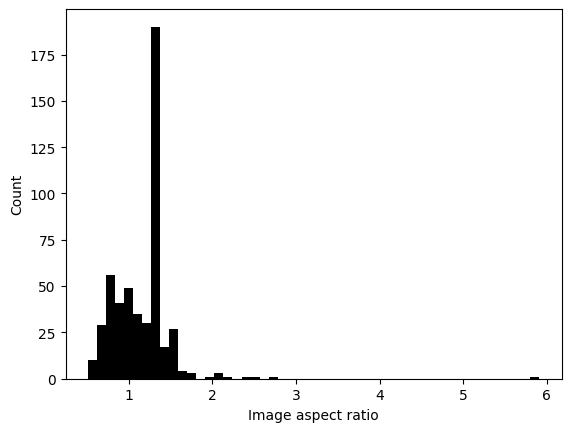

In [12]:
# Calculate the sample image aspect ratios
aspect_ratios=np.array(widths)/np.array(heights)

# Plot as histogram
plt.hist(aspect_ratios, bins=50, color='black')
plt.xlabel('Image aspect ratio')
plt.ylabel('Count')
plt.show()

In [13]:
aspect_ratio=4/3

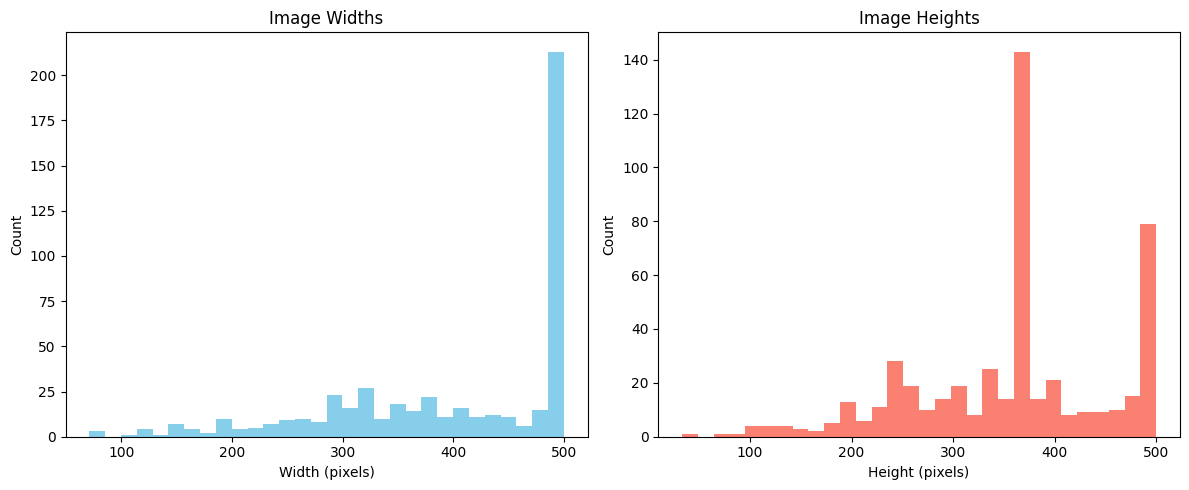

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=30, color='skyblue')
plt.title("Image Widths")
plt.xlabel("Width (pixels)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.hist(heights, bins=30, color='salmon')
plt.title("Image Heights")
plt.xlabel("Height (pixels)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [15]:
from typing import Tuple

def make_datasets(
        training_data_path: str,
        image_width: int,
        image_height: int, 
        batch_size: int=32,
        steps_per_epoch: int=50,
        epochs: int=10
) -> Tuple[tf.data.Dataset, tf.data.Dataset]:

    training_dataset, validation_dataset=tf.keras.utils.image_dataset_from_directory(
        training_data_path,
        validation_split=0.2,
        subset='both',
        seed=315,
        shuffle=True,
        image_size=(image_width, image_height),
        batch_size=batch_size
    )

    epoch_images=batch_size*steps_per_epoch
    total_images=epoch_images*epochs

    training_dataset=training_dataset.cache().shuffle(total_images, reshuffle_each_iteration=True).prefetch(buffer_size=total_images).repeat()
    validation_dataset=training_dataset.cache().shuffle(total_images, reshuffle_each_iteration=True).prefetch(buffer_size=total_images).repeat()

    return training_dataset, validation_dataset


training_dataset, validation_dataset=make_datasets(
    training_data_path,
    image_width=64,
    image_height=48,
    batch_size=64,
    steps_per_epoch=50,
    epochs=100
)

Found 21000 files belonging to 2 classes.
Using 16800 files for training.
Using 4200 files for validation.


### 3.1. Model definition

In [16]:
def compile_model(image_width, image_height, learning_rate):

    initializer=tf.keras.initializers.GlorotUniform(seed=315)

    model=Sequential([
        layers.Input((image_width, image_height, 3)),
        layers.Rescaling(1./255),
        layers.Conv2D(16, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer=initializer),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(1, activation='sigmoid', kernel_initializer=initializer)
    ])

    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])

    return model


model=compile_model(
    image_width=64,
    image_height=48, 
    learning_rate=0.1
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 64, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 48, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 24, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       393,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 417,057 (1.59 MB)

 Trainable params: 417,057 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

### 3.2. Model training

In [17]:
training_results=model.fit(
  training_dataset,
  validation_data=validation_dataset,
  epochs=100,
  steps_per_epoch=50,
  validation_steps=50,
  verbose=0
)
print()

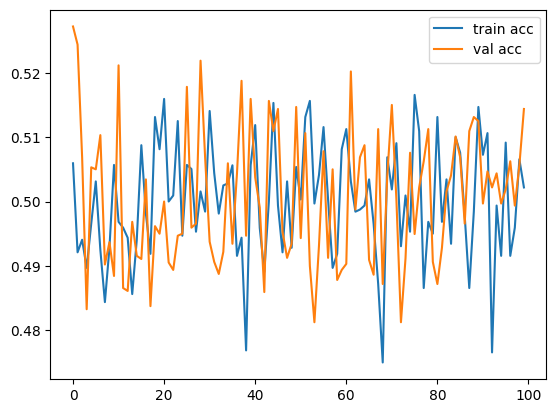

In [18]:
import matplotlib.pyplot as plt

plt.plot(training_results.history['binary_accuracy'], label='train acc')
plt.plot(training_results.history['val_binary_accuracy'], label='val acc')
plt.legend()
plt.show()

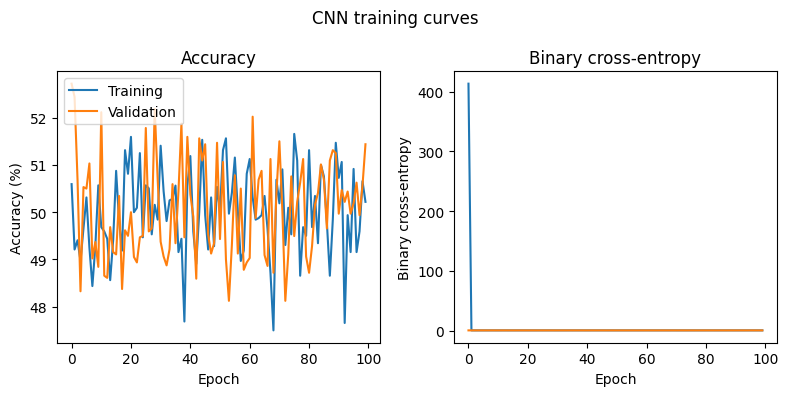

In [19]:
# Take a look the information 'training_results' contains. Plot the training 
# and validation accuracy (and binary cross-entropy if you like) over the
# training epochs. Is the model learning? If not, what do you think
# is wrong?
 
# Set-up a 1x2 figure for accuracy and binary cross-entropy
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('CNN training curves', size='large')

# Plot training and validation accuracy
axs[0].set_title('Accuracy')
axs[0].plot(np.array(training_results.history['binary_accuracy']) * 100, label='Training')
axs[0].plot(np.array(training_results.history['val_binary_accuracy']) * 100, label='Validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].legend(loc='upper left')

# Plot training and validation binary cross-entropy
axs[1].set_title('Binary cross-entropy')
axs[1].plot(training_results.history['loss'])
axs[1].plot(training_results.history['val_loss'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Binary cross-entropy')

# Show the plot
fig.tight_layout()

I am the right function
Optimization run already complete, loading results from disk.


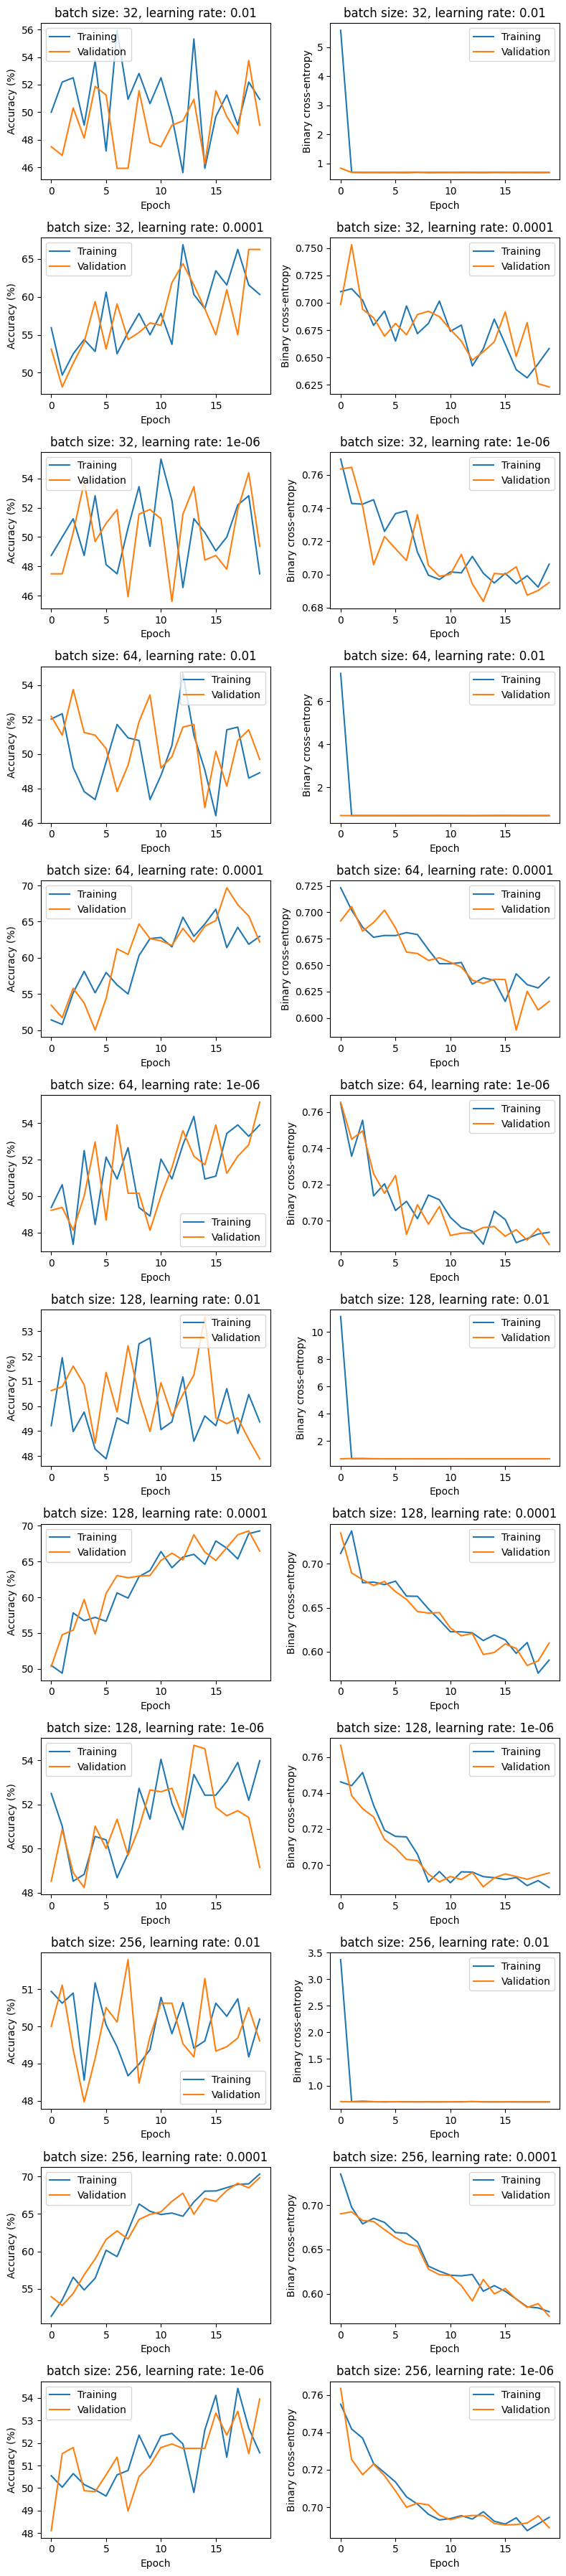

In [20]:
import utils 

# Define hyperparameters
hyperparameters={
    'batch_sizes': [32, 64, 128, 256],
    'image_widths': [128],
    'learning_rates': [0.01, 0.0001, 0.000001]
}

# Train the model with each set of hyperparameters
hyperparameter_optimization_results= utils.hyperparameter_optimization_run(
    training_data_path,
    **hyperparameters
)

# Specify which hyperparameters to include in the plot labels
plot_labels=['batch_sizes', 'learning_rates']

# Plot the learning curves
utils.plot_hyperparameter_optimization_run(
    hyperparameter_optimization_results,
    hyperparameters,
    plot_labels
).show()

print()

Training run already complete, loading results from disk.


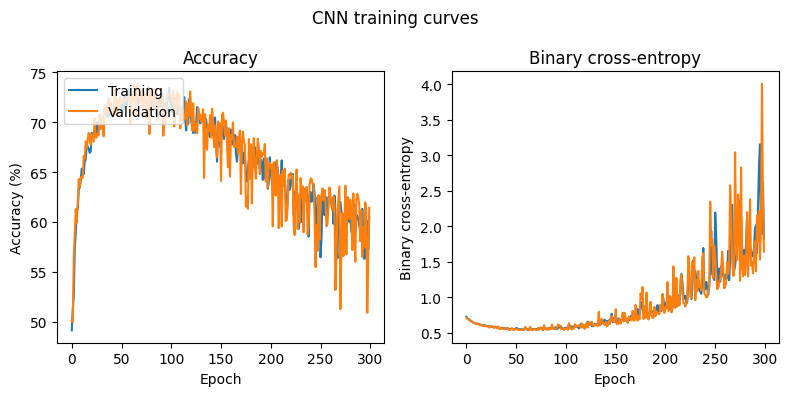

In [21]:
experiment_results={}
# Set some hyperparameters for the run
hyperparameters={'batch_size': 256, 'learning_rate': 0.0001, 'epochs': 300, 'aspect_ratio': 4/3}

# Do a single training run
training_results=utils.single_training_run(training_data_path, **hyperparameters)

# Collect the results so we can plot all of the experiments together at the end
experiment_results['Optimized model']=training_results

# Plot the results
utils.plot_single_training_run(training_results).show()

print()

Training run already complete, loading results from disk.


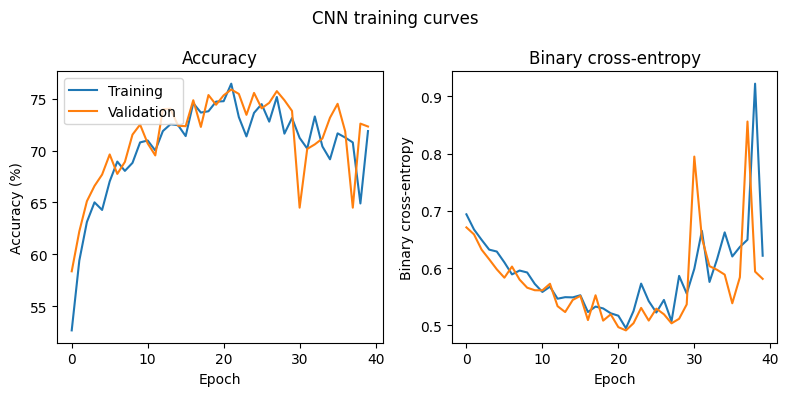

In [22]:
experiment_results={}
# Set some hyperparameters for the run
hyperparameters={'batch_size': 128, 'learning_rate': 0.0001, 'epochs': 40, 'aspect_ratio': 4/3, 'image_width': 128} 

# Do a single training run
training_results=utils.single_training_run(training_data_path, **hyperparameters)

# Collect the results so we can plot all of the experiments together at the end
experiment_results['Optimized model']=training_results

# Plot the results
utils.plot_single_training_run(training_results).show()

print()

In [23]:
training_results.model.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_9 (Normalization) │ (None, 128, 96, 1)     │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 126, 94, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 63, 47, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 61, 45, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 30, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 28, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 14, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 8960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 128)            │     1,147,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,535,880 (13.49 MB)

 Trainable params: 1,178,625 (4.50 MB)

 Non-trainable params: 3 (16.00 B)

 Optimizer params: 2,357,252 (8.99 MB)

In [36]:
testing_dataset = tf.keras.utils.image_dataset_from_directory(
    testing_data_path,
    image_size=(128, 96),      # match (128, 96)
    color_mode='grayscale',    # match 1 channel
    batch_size=None
)

Found 4000 files belonging to 2 classes.


In [37]:
for x, y in testing_dataset.take(1):
    print("Image batch shape:", x.shape)  # should be (128, 96, 3)

Image batch shape: (128, 96, 1)


In [38]:
print(training_results.model.input_shape)

(None, 128, 96, 1)


In [44]:
from sklearn.metrics import accuracy_score
threshold = 0.5

images = []
labels = []

for x, y in testing_dataset:
    images.append(x.numpy())       # (128, 96, 1)
    labels.append(y.numpy())       # scalar (0 or 1)

print(images[0].shape)             # sanity check

images = np.stack(images)         # instead of vstack
labels = np.array(labels)         # shape (N,)

predictions = training_results.model.predict(images)
predictions = [1 if p > threshold else 0 for p in predictions]

accuracy = accuracy_score(predictions, labels) * 100
print(f"Accuracy: {accuracy:.2f}%")

(128, 96, 1)
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 69.60%


In [45]:
print(images[0].shape)

(128, 96, 1)


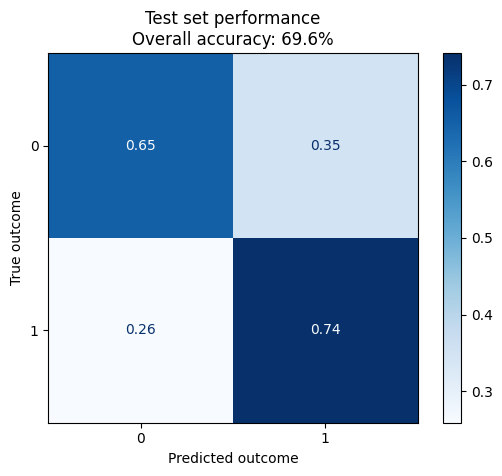

In [47]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

accuracy = accuracy_score(labels, predictions) * 100

# Compute normalized confusion matrix
cm = confusion_matrix(labels, predictions, normalize='true')
cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Plot it
cm_disp.plot(cmap='Blues', values_format=".2f")
plt.title(f'Test set performance\nOverall accuracy: {accuracy:.1f}%')
plt.xlabel('Predicted outcome')
plt.ylabel('True outcome')
plt.show()

In [65]:
from tensorflow.keras import layers, models, Input


input_layer = Input(shape=(128, 96, 1))

x = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

new_model = models.Model(inputs=input_layer, outputs=output)
new_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [66]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 96, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze for now

new_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation='sigmoid')  # binary classification
])



images = []
labels = []

for x, y in testing_dataset:
    images.append(x.numpy())
    labels.append(y.numpy())

images = np.stack(images)      # shape: (N, height, width, channels)
labels = np.array(labels)      # shape: (N,)

/var/folders/v_/2k7y736n7x103htcsntppd6r0000gn/T/ipykernel_84329/3720939388.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


In [71]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze for feature extraction

model = models.Sequential([
    layers.Rescaling(1./255),  # normalize
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')  # binary classifier
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [72]:
testing_dataset = tf.keras.utils.image_dataset_from_directory(
    testing_data_path,
    image_size=(128, 128),     # square, matches MobileNetV2
    color_mode='rgb',          # MobileNet expects RGB
    batch_size=None            # no batching for now
)

Found 4000 files belonging to 2 classes.


In [73]:
images = []
labels = []

for x, y in testing_dataset:
    images.append(x.numpy())
    labels.append(y.numpy())

images = np.stack(images).astype(np.float32)  # (N, 128, 128, 3)
labels = np.array(labels)                     # (N,)

In [74]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

base_model = MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze for feature extraction

model = models.Sequential([
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')  # binary classifier
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [75]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    training_data_path,
    image_size=(128, 128),
    color_mode='rgb',
    batch_size=32
)

# Optional: Add validation_split here if needed
model.fit(train_dataset, epochs=5)

Found 21000 files belonging to 2 classes.
Epoch 1/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 25s 34ms/step - accuracy: 0.9211 - loss: 0.1779
Epoch 2/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9692 - loss: 0.0772
Epoch 3/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.9725 - loss: 0.0690
Epoch 4/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.9741 - loss: 0.0648
Epoch 5/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - accuracy: 0.9759 - loss: 0.0612


In [76]:
preds = model.predict(images)
predictions = (preds.flatten() > 0.5).astype(int)

125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step


Test Accuracy: 96.60%


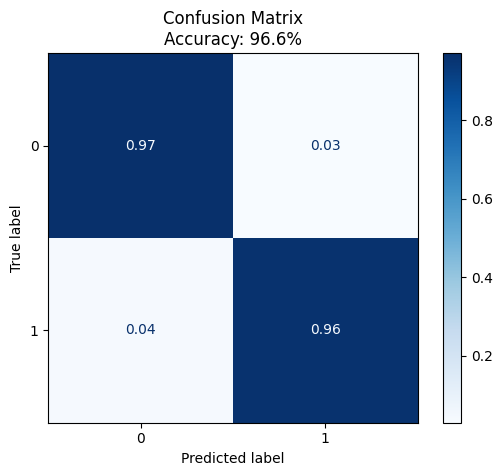

In [77]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

accuracy = accuracy_score(labels, predictions) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

cm = confusion_matrix(labels, predictions, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format=".2f")
plt.title(f'Confusion Matrix\nAccuracy: {accuracy:.1f}%')
plt.show()